#### Libraries importation

In [59]:
# Librearies importation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json # library to handle JSON files
import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

### Foursquare credentials

In [60]:
CLIENT_ID = 'ZC4IJRQBYU4FUZKXVZKHACJAHMUNQXEUVZ4LR4CSM1RCGC1O' # your Foursquare ID
CLIENT_SECRET = 'JJER2S2X5WPSXY2EEMFCVGHQUDBAR0N0DSDPCFNFC1II1RKU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
Limit = 300
Radius = 500

### Function definition to retrieve venues data from Foursquare

In [61]:
## Function request_venues() make a Foursquare request for 1 position (latitude,longitude) and
## return a dict with containing venues datas
def request_venues(df,n):
    latitude = df['latitude'][n]
    longitude = df['longitude'][n]
    url = 'https://api.foursquare.com/v2/venues/explore'
    params = dict(client_id = CLIENT_ID,
              client_secret=CLIENT_SECRET,
              v=VERSION,
              ll=f'{latitude},{longitude}',
              categoryId = '4d4b7105d754a06374d81259', #Corresponding to restaurants
              radius=Radius,
              limit=Limit)

    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)
    data = data['response']['groups'][0]['items']
    return data

In [62]:
## Function venue_category() extract the list of categroies from request_venue() result
## and put it into a dataframe.
def Venue_category(data):
    liste_categories = []
    for n in range(0,len(data)):
        liste_categories.append(data[n]['venue']['categories'][0]['name'])
    return pd.DataFrame(liste_categories)

In [63]:
## get_venues() function uses request_venues() and Venue_categroy() to built a dataframe
## that list the venues for each rows (lat,lng position) of df
def get_venues(df): 
    data = pd.DataFrame()
    index = []
    for n in range(0,df.shape[0]):
        index.append(df['place_name'][n])
        data[df['place_name'][n]] = Venue_category(request_venues(df,n))[0]               
    return data

### Geolocalisation of my clients places from French Gouv database

In [64]:
liste_lieux = ['Paris 1er','Paris 2eme','Paris 3eme','Paris 4eme','Paris 5eme','Paris 6eme',
               'Paris 7eme','Paris 8eme','Paris 9eme','Paris 10eme','Paris 11eme',
                'Paris 13eme','Paris 14eme','Paris 15eme','Paris 16eme','Paris 17eme',
                'Paris 18eme','Paris 19eme','Paris 20eme']
               
    # 'Corbeil-Essonnes','Bobigny','Champigny-sur-marne','Versaille','Pontault Combault',
    #'Melun', 'Sceaux', 'Cergy-Pontoise','Nanterre','Argenteuil', 'Villepinte','Chelles',
    #'vigneux sur seine'] # Cities 

df = pd.DataFrame(index=liste_lieux,columns=['latitude','longitude'])

for ville in liste_lieux:
    params = (('q',ville),('limit','1'))
    response = requests.get('https://api-adresse.data.gouv.fr/search/', params=params)
    data = json.loads(response.text)
    df.loc[ville,'latitude'] = data['features'][0]['geometry']['coordinates'][1]
    df.loc[ville,'longitude'] = data['features'][0]['geometry']['coordinates'][0]

df = df.reset_index()
df.columns=['place_name','latitude','longitude']
df

,place_name,latitude,longitude
0,Paris 1er,48.8621,2.33621
1,Paris 2eme,48.8677,2.34116
2,Paris 3eme,48.8625,2.35932
3,Paris 4eme,48.8544,2.35692
4,Paris 5eme,48.8453,2.35058
5,Paris 6eme,48.8491,2.33049
6,Paris 7eme,48.8547,2.31208
7,Paris 8eme,48.8736,2.3116
8,Paris 9eme,48.877,2.33789
9,Paris 10eme,48.8761,2.36227


In [65]:
#Paris geoloc:
latitude_paris = 48.8534
longitude_paris = 2.3488
map_IDF = folium.Map(location=[latitude_paris,longitude_paris],zoom_start=12)

# add markers to map
for lat,lgt,nom in zip(df['latitude'], 
                       df['longitude'], 
                       df['place_name']):
    label = f'{nom}'
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat,lgt],
        radius=500,
        #popup=label,
        color='red',
        fill=True,
        fill_color=None,
        fill_opacity=0.1,
        parse_html=False).add_to(map_IDF)
    folium.CircleMarker(
        [lat, lgt],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5,
        parse_html=False).add_to(map_IDF)
    


map_IDF

### For each place, retrieving the list of the most popular restaurant in the area

In [68]:
df_venues = get_venues(df)

In [81]:
df_v1 = df_venues.transpose()
df_v1

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
Paris 1er,Italian Restaurant,Café,Café,Italian Restaurant,Bakery,Udon Restaurant,Japanese Restaurant,Ramen Restaurant,Restaurant,Japanese Restaurant,...,Café,French Restaurant,Chinese Restaurant,Restaurant,Japanese Restaurant,Italian Restaurant,Italian Restaurant,Gastropub,Café,Sushi Restaurant
Paris 2eme,French Restaurant,Bistro,Italian Restaurant,French Restaurant,Pizza Place,Tapas Restaurant,Bakery,French Restaurant,French Restaurant,Sushi Restaurant,...,French Restaurant,Thai Restaurant,Restaurant,Bakery,Creperie,Japanese Restaurant,Korean Restaurant,Restaurant,Restaurant,Japanese Restaurant
Paris 3eme,Sandwich Place,Sandwich Place,Okonomiyaki Restaurant,Sandwich Place,Burger Joint,Japanese Restaurant,Japanese Restaurant,Restaurant,Café,French Restaurant,...,French Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,French Restaurant,Chinese Restaurant,Chinese Restaurant,Italian Restaurant,Falafel Restaurant,Brasserie
Paris 4eme,French Restaurant,Restaurant,Scandinavian Restaurant,French Restaurant,Portuguese Restaurant,Creperie,Café,Bistro,Burgundian Restaurant,Italian Restaurant,...,Creperie,Asian Restaurant,French Restaurant,Gastropub,Creperie,French Restaurant,Japanese Restaurant,Bistro,Italian Restaurant,French Restaurant
Paris 5eme,Bakery,Café,Korean Restaurant,French Restaurant,French Restaurant,French Restaurant,French Restaurant,Portuguese Restaurant,Creperie,Sushi Restaurant,...,Lebanese Restaurant,Pizza Place,Kebab Restaurant,Argentinian Restaurant,Basque Restaurant,Gastropub,Auvergne Restaurant,French Restaurant,Vietnamese Restaurant,French Restaurant
Paris 6eme,French Restaurant,Bakery,Bakery,Italian Restaurant,Bistro,Café,Pizza Place,French Restaurant,French Restaurant,Japanese Restaurant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Paris 7eme,French Restaurant,French Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,French Restaurant,Café,Diner,Bistro,Korean Restaurant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Paris 8eme,French Restaurant,French Restaurant,French Restaurant,Steakhouse,French Restaurant,Italian Restaurant,Corsican Restaurant,French Restaurant,Japanese Restaurant,Italian Restaurant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Paris 9eme,Vegetarian / Vegan Restaurant,French Restaurant,Bistro,French Restaurant,Bakery,Venezuelan Restaurant,Seafood Restaurant,Bakery,Latin American Restaurant,Japanese Restaurant,...,Café,Italian Restaurant,Korean Restaurant,Argentinian Restaurant,Japanese Restaurant,Mexican Restaurant,Restaurant,French Restaurant,Restaurant,Japanese Restaurant
Paris 10eme,French Restaurant,Thai Restaurant,Mediterranean Restaurant,Taco Place,Café,Café,Asian Restaurant,Creperie,Burger Joint,Japanese Restaurant,...,Italian Restaurant,Middle Eastern Restaurant,Sandwich Place,Burger Joint,Café,Japanese Restaurant,Bakery,Asian Restaurant,Brasserie,Indian Restaurant


### Transforming the features columns into dummies and appling a function to each raw to get the probability for each features

In [134]:
df_v = pd.get_dummies(df_v1,prefix='',prefix_sep='')
df_v = df_v.groupby(level=0,axis=1).sum()
df_v=df_v.apply(lambda x : x/df_v.sum(axis=1),axis = 0)
df_v

,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bagel Shop,Bakery,Basque Restaurant,Bistro,...,Taco Place,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
Paris 1er,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706,0.044118,0.000000,0.014706,...,0.014706,0.000000,0.029412,0.000000,0.000000,0.044118,0.000000,0.000000,0.000000,0.000000
Paris 2eme,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044118,0.000000,0.044118,...,0.000000,0.014706,0.014706,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000
Paris 3eme,0.000000,0.000000,0.000000,0.000000,0.014706,0.014706,0.000000,0.029412,0.000000,0.029412,...,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000,0.029412,0.000000,0.044118,0.000000
Paris 4eme,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.029412,0.000000,0.029412,...,0.000000,0.044118,0.044118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Paris 5eme,0.000000,0.000000,0.000000,0.014706,0.000000,0.014706,0.000000,0.058824,0.014706,0.029412,...,0.000000,0.014706,0.000000,0.014706,0.014706,0.000000,0.000000,0.000000,0.044118,0.000000
Paris 6eme,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.066667,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Paris 7eme,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.019608,0.058824,0.019608,0.039216,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.000000,0.000000
Paris 8eme,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.063830,0.000000,0.021277,...,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Paris 9eme,0.000000,0.014706,0.000000,0.014706,0.000000,0.000000,0.000000,0.058824,0.000000,0.058824,...,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.029412,0.014706,0.014706,0.000000
Paris 10eme,0.000000,0.029412,0.000000,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.058824,...,0.014706,0.000000,0.044118,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000


In [114]:
df_v.sum(axis=1)

Paris 1er      1.0
Paris 2eme     1.0
Paris 3eme     1.0
Paris 4eme     1.0
Paris 5eme     1.0
Paris 6eme     1.0
Paris 7eme     1.0
Paris 8eme     1.0
Paris 9eme     1.0
Paris 10eme    1.0
Paris 11eme    1.0
Paris 13eme    1.0
Paris 14eme    1.0
Paris 15eme    1.0
Paris 16eme    1.0
Paris 17eme    1.0
Paris 18eme    1.0
Paris 19eme    1.0
Paris 20eme    1.0
dtype: float64

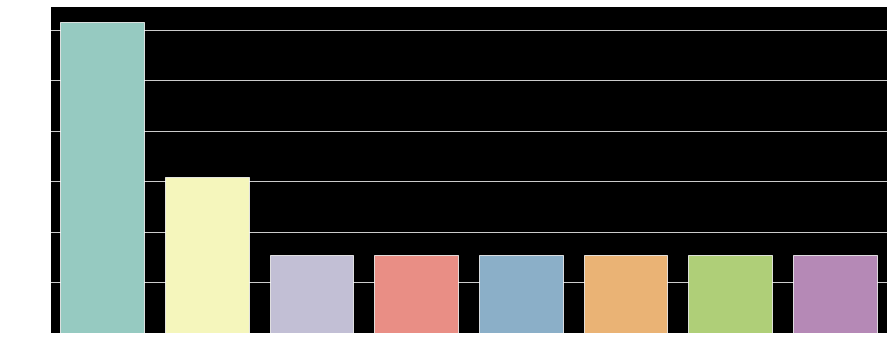

In [132]:
df_13 = df_v.transpose()['Paris 13eme'].sort_values(ascending=False)[0:8].to_frame()
df_13
plt.figure(figsize=(15,6))
sns.barplot(x = df_13.index, y =df_13['Paris 13eme'] ) 

### Using KMean clustering method to make clusters out of the differents places

In [135]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_v)
df_v['Cluster label'] = kmeans.labels_
kmeans.labels_
df_v

,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bagel Shop,Bakery,Basque Restaurant,Bistro,...,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Cluster label
Paris 1er,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706,0.044118,0.000000,0.014706,...,0.000000,0.029412,0.000000,0.000000,0.044118,0.000000,0.000000,0.000000,0.000000,2
Paris 2eme,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044118,0.000000,0.044118,...,0.014706,0.014706,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,2
Paris 3eme,0.000000,0.000000,0.000000,0.000000,0.014706,0.014706,0.000000,0.029412,0.000000,0.029412,...,0.000000,0.014706,0.000000,0.000000,0.000000,0.029412,0.000000,0.044118,0.000000,4
Paris 4eme,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.029412,0.000000,0.029412,...,0.044118,0.044118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Paris 5eme,0.000000,0.000000,0.000000,0.014706,0.000000,0.014706,0.000000,0.058824,0.014706,0.029412,...,0.014706,0.000000,0.014706,0.014706,0.000000,0.000000,0.000000,0.044118,0.000000,1
Paris 6eme,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.066667,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Paris 7eme,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.019608,0.058824,0.019608,0.039216,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.000000,0.000000,1
Paris 8eme,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.063830,0.000000,0.021277,...,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Paris 9eme,0.000000,0.014706,0.000000,0.014706,0.000000,0.000000,0.000000,0.058824,0.000000,0.058824,...,0.000000,0.000000,0.000000,0.029412,0.000000,0.029412,0.014706,0.014706,0.000000,1
Paris 10eme,0.000000,0.029412,0.000000,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.058824,...,0.000000,0.044118,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000,4


In [136]:
cols = df_v.columns.to_list()
cols = ['Cluster label'] + [col for col in cols if col != 'Cluster label']
df_v=df_v[cols]
df_v2 = df_v.reset_index()
df_v2.rename(columns={'index': 'place_name'}, inplace=True)
df_v2

,place_name,Cluster label,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bagel Shop,Bakery,...,Taco Place,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Paris 1er,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706,0.044118,...,0.014706,0.000000,0.029412,0.000000,0.000000,0.044118,0.000000,0.000000,0.000000,0.000000
1,Paris 2eme,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044118,...,0.000000,0.014706,0.014706,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000
2,Paris 3eme,4,0.000000,0.000000,0.000000,0.000000,0.014706,0.014706,0.000000,0.029412,...,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000,0.029412,0.000000,0.044118,0.000000
3,Paris 4eme,1,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.029412,...,0.000000,0.044118,0.044118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Paris 5eme,1,0.000000,0.000000,0.000000,0.014706,0.000000,0.014706,0.000000,0.058824,...,0.000000,0.014706,0.000000,0.014706,0.014706,0.000000,0.000000,0.000000,0.044118,0.000000
5,Paris 6eme,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Paris 7eme,1,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.019608,0.058824,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.000000,0.000000
7,Paris 8eme,1,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.063830,...,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Paris 9eme,1,0.000000,0.014706,0.000000,0.014706,0.000000,0.000000,0.000000,0.058824,...,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.029412,0.014706,0.014706,0.000000
9,Paris 10eme,4,0.000000,0.029412,0.000000,0.000000,0.058824,0.000000,0.000000,0.029412,...,0.014706,0.000000,0.044118,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000


### Hereafter the result of the clustering process

In [137]:
df_label = pd.merge(df,df_v2,on='place_name')
df_label = df_label[['place_name','latitude','longitude','Cluster label']]
df_label

,place_name,latitude,longitude,Cluster label
0,Paris 1er,48.8621,2.33621,2
1,Paris 2eme,48.8677,2.34116,2
2,Paris 3eme,48.8625,2.35932,4
3,Paris 4eme,48.8544,2.35692,1
4,Paris 5eme,48.8453,2.35058,1
5,Paris 6eme,48.8491,2.33049,1
6,Paris 7eme,48.8547,2.31208,1
7,Paris 8eme,48.8736,2.3116,1
8,Paris 9eme,48.877,2.33789,1
9,Paris 10eme,48.8761,2.36227,4


In [110]:
#Paris geoloc:
latitude_paris = 48.8534
longitude_paris = 2.3488
map_IDF = folium.Map(location=[latitude_paris,longitude_paris],zoom_start=12)

# add markers to map
for lat,lgt,nom,lab in zip(df_label['latitude'], 
                       df_label['longitude'], 
                       df_label['place_name'],
                       df_label['Cluster label']):
    
    color = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow','purple','darkmagenta']
    label = f'{nom}'
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat,lgt],
        radius=500,
        #popup=label,
        color='black',
        fill=False,
        fill_color=None,
        fill_opacity=0.1,
        parse_html=False).add_to(map_IDF)
         
    folium.CircleMarker(
        [lat, lgt],
        radius=5,
        popup=label,
        color=color[lab],
        fill=True,
        fill_color=color[lab],
        fill_opacity=0.5,
        parse_html=False).add_to(map_IDF)

map_IDF

### Clustering process successful as the current business is clustered with 6 other neighborhood